Installing EconML packages

In [1]:
!pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: shap
    Found existin

In [1]:
!pip install -U scikit-learn==1.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 110.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
econml 0.15.1 requires scikit-learn<1.6,>=1.0, but you have scikit-learn 1.6.0 which is incompatible.


Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from econml.dml import DML

Simulate Datasets

In [5]:
import numpy as np
import pandas as pd

np.random.seed(42)

years = [2018, 2019, 2020, 2021]
regions = ['Treated', 'Control']
rows = []

for region in regions:
    for year in years:
        base = 80
        if region == 'Control':
            base += 2
        if year >= 2020:
            base += 3
        treatment_effect = -5 if (region == 'Treated' and year >= 2020) else 0
        noise = np.random.normal(0, 1)
        emp_rate = base + treatment_effect + noise
        rows.append([region, year, emp_rate])

df = pd.DataFrame(rows, columns=['region', 'year', 'employment_rate'])
df['treatment'] = (df['region'] == 'Treated').astype(int)
df['post'] = (df['year'] >= 2020).astype(int)
df['treat_post'] = df['treatment'] * df['post']

df.head()

,region,year,employment_rate,treatment,post,treat_post
0,Treated,2018,80.496714,1,0,0
1,Treated,2019,79.861736,1,0,0
2,Treated,2020,78.647689,1,1,1
3,Treated,2021,79.523030,1,1,1
4,Control,2018,81.765847,0,0,0


Visualize the employment trends

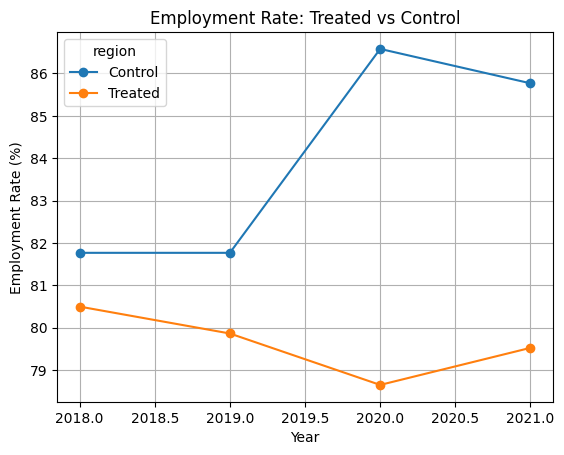

In [7]:
import matplotlib.pyplot as plt

df.groupby(['region', 'year'])['employment_rate'].mean().unstack().T.plot(marker='o')
plt.title("Employment Rate: Treated vs Control")
plt.ylabel("Employment Rate (%)")
plt.xlabel("Year")
plt.grid(True)
plt.show()

Saving the plot

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
plot_path = '/content/drive/MyDrive/causal_minwage_policy/employment_rate_trend.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

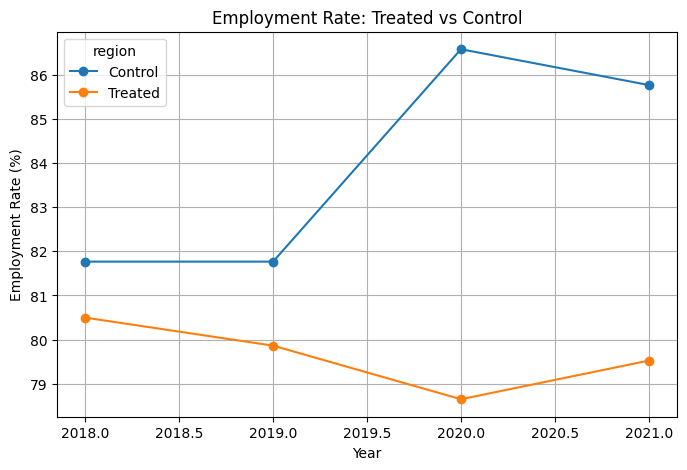

In [10]:
import matplotlib.pyplot as plt

# Step 1: Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Step 2: Group and plot on axis
plot_data = df.groupby(['region', 'year'])['employment_rate'].mean().unstack().T
plot_data.plot(marker='o', ax=ax)

# Step 3: Add titles and labels
ax.set_title("Employment Rate: Treated vs Control")
ax.set_ylabel("Employment Rate (%)")
ax.set_xlabel("Year")
ax.grid(True)

# Step 4: Save before showing
plot_path = '/content/drive/MyDrive/causal_minwage_policy/employment_rate_trend.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')

# Step 5: Show the plot
plt.show()

Econometric modeling

We want to estimate the Average Treatment Effect (ATE) of a minimum wage policy introduced in 2020, affecting the treated group (e.g., certain states or regions).

In [11]:
Y = df['employment_rate'].values
T = df['treat_post'].values
X = df[['treatment', 'post']].values

Running Double Machine Learning (DML)

In [13]:
from sklearn.linear_model import LinearRegression
from econml.dml import DML

model_y = LinearRegression()
model_t = LinearRegression()
model_final = LinearRegression()

dml = DML(model_y=model_y,
          model_t=model_t,
          model_final=model_final,
          discrete_treatment=True,
          random_state=0)

dml.fit(Y, T, X=X)

In [15]:
# Get individual treatment effects
treatment_effects = dml.ate(X)

# Take the average ATE
ate = treatment_effects.mean()

# Print
print(f"Estimated Causal Effect (ATE): {ate:.2f}")

Estimated Causal Effect (ATE): -5.50


**What This Means:**
This tells us that, on average, the introduction of the minimum wage policy reduced employment rate by ~5.5 percentage points in the treated region post-2020

let’s now do a classic OLS-based Difference-in-Differences (DiD) estimation using statsmodels

In [16]:
!pip install statsmodels

In [17]:
# Re-construct key treatment variables if needed
df['treatment'] = (df['region'] == 'Treated').astype(int)
df['post'] = (df['year'] >= 2020).astype(int)
df['treat_post'] = df['treatment'] * df['post']

# Check first few rows
df.head()

,region,year,employment_rate,treatment,post,treat_post
0,Treated,2018,80.496714,1,0,0
1,Treated,2019,79.861736,1,0,0
2,Treated,2020,78.647689,1,1,1
3,Treated,2021,79.523030,1,1,1
4,Control,2018,81.765847,0,0,0


Run OLS Regression with DiD

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Run the DiD regression
model = smf.ols('employment_rate ~ treatment + post + treat_post', data=df).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        employment_rate   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     84.95
Date:                Wed, 09 Jul 2025   Prob (F-statistic):           0.000445
Time:                        14:49:49   Log-Likelihood:                -2.6749
No. Observations:                   8   AIC:                             13.35
Df Residuals:                       4   BIC:                             13.67
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.7659      0.338    241.878      0.0

Saving the results

In [19]:
# Save OLS regression summary to Drive
with open('/content/drive/MyDrive/causal_minwage_policy/ols_did_summary.txt', 'w') as f:
    f.write(model.summary().as_text())